<a href="https://www.kaggle.com/code/veeraj16/bci-on-cnn-lstm?scriptVersionId=253180561" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-motor-imagery-bciciv-2a/BCICIV_2a_all_patients.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_1.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_2.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_4.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_8.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_7.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_6.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_5.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_9.csv
/kaggle/input/eeg-motor-imagery-bciciv-2a/patients/patients/BCICIV_2a_3.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random


2025-07-29 18:01:36.158399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753812096.576431      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753812096.688623      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/eeg-motor-imagery-bciciv-2a/BCICIV_2a_all_patients.csv")

# Drop NA just in case (though this dataset has none)
df = df.dropna()

# EEG columns (starting from column 4 onwards)
eeg_columns = df.columns[4:]

print("Channels used:", eeg_columns)

Channels used: Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')


# *Preprocessing***

In [4]:
df['label'].unique()

array(['tongue', 'foot', 'right', 'left'], dtype=object)

In [5]:
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# Check class distribution
print("Class distribution before windowing:")
print(df['label'].value_counts())

# Group by epochs
grouped = df.groupby('epoch')
X, y = [], []

target_length = 201

for epoch, group in grouped:
    data = group[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    X.append(data)
    y.append(group['label'].iloc[0])

X = np.array(X)
y = np.array(y)
print(f"X shape after epoch grouping: {X.shape}")
print(f"y shape: {y.shape}")

# Channel-wise normalization
n_samples, n_channels, n_time_points = X.shape
X_normalized = np.zeros_like(X)

for i in range(n_samples):
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_normalized[i, ch, :] = scaler.fit_transform(X[i, ch, :].reshape(-1, 1)).flatten()

# Frequency-domain features
X_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(X_normalized[i, ch, :])
        X_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

# Sliding window
window_size = 50
stride = 10
X_windows, y_windows = [], []

for i in range(n_samples):
    data = X_normalized[i]
    freq_data = X_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]

        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]

        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]

        combined = np.stack([window, freq_window], axis=-1)
        X_windows.append(combined)
        y_windows.append(y[i])

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)
print(f"X_windows shape (before reshape): {X_windows.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Encoded y shape (categorical): {y_categorical.shape}")

# Reshape: (samples, time_steps, channels, features) -> (samples, time_steps, channels * features)
X_windows = X_windows.transpose(0, 2, 1, 3)
X_windows = X_windows.reshape(X_windows.shape[0], X_windows.shape[1], X_windows.shape[2] * X_windows.shape[3])
print(f"X_windows shape (final): {X_windows.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Class distribution before windowing:
label
left      130248
right     130248
foot      115776
tongue    115776
Name: count, dtype: int64
X shape after epoch grouping: (632, 22, 201)
y shape: (632,)
X_windows shape (before reshape): (10112, 22, 50, 2)
Encoded y shape (categorical): (10112, 4)
X_windows shape (final): (10112, 50, 44)
Train: (8089, 50, 44), (8089, 4)
Test: (2023, 50, 44), (2023, 4)


# Visualizations

--- Raw EEG Signal Visualization (Sample) ---


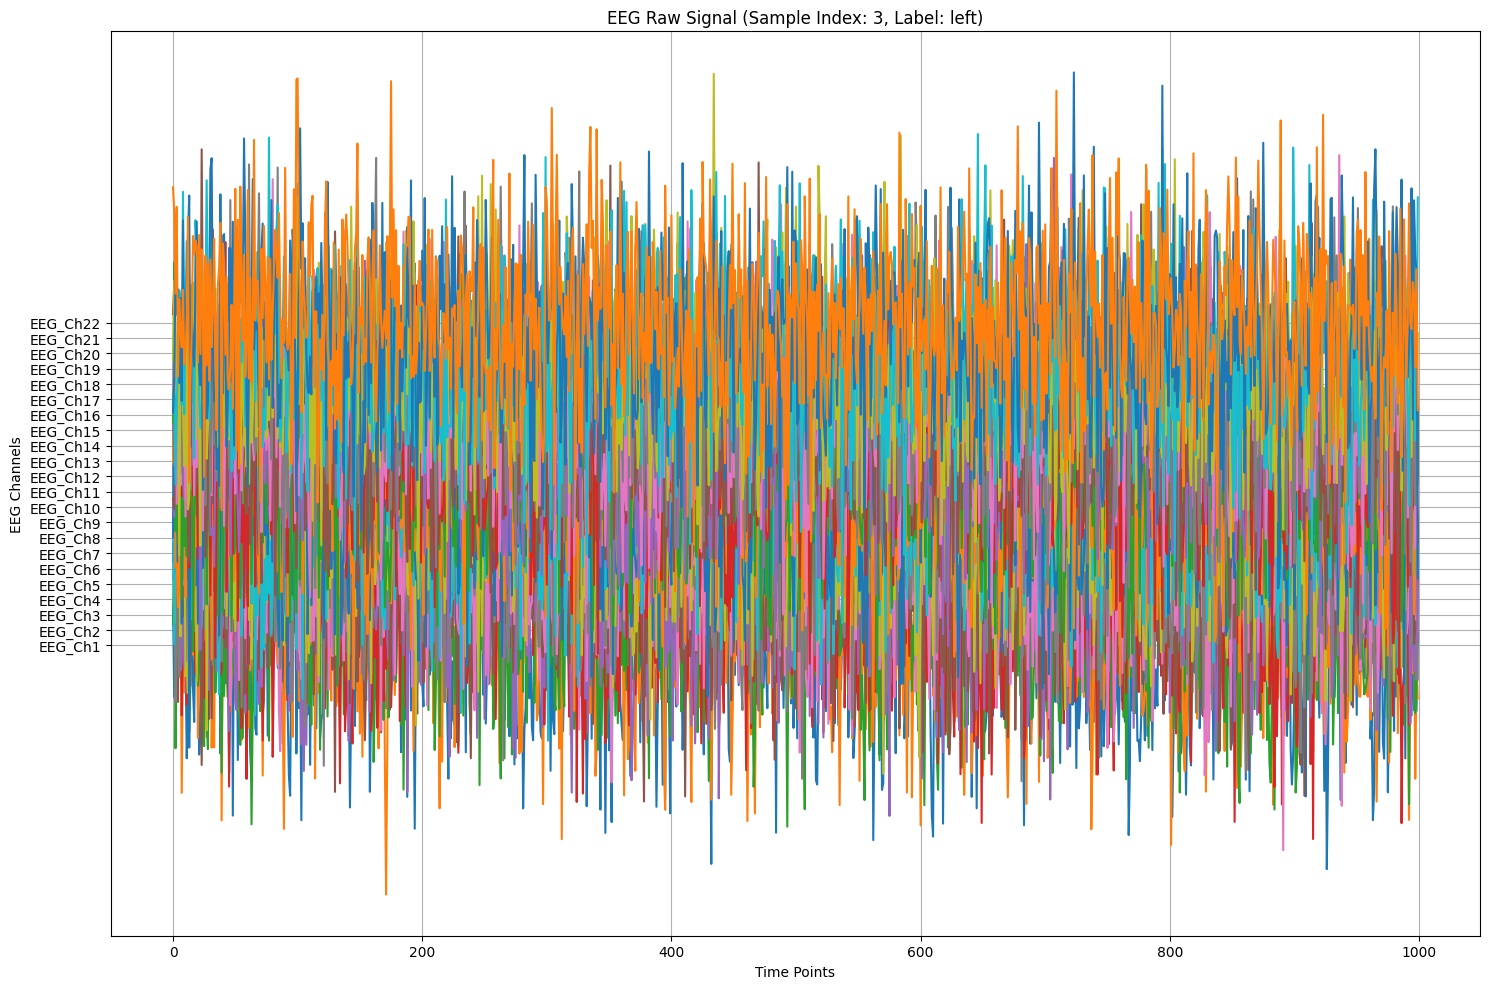


--- Raw vs. Normalized EEG Signal Comparison ---


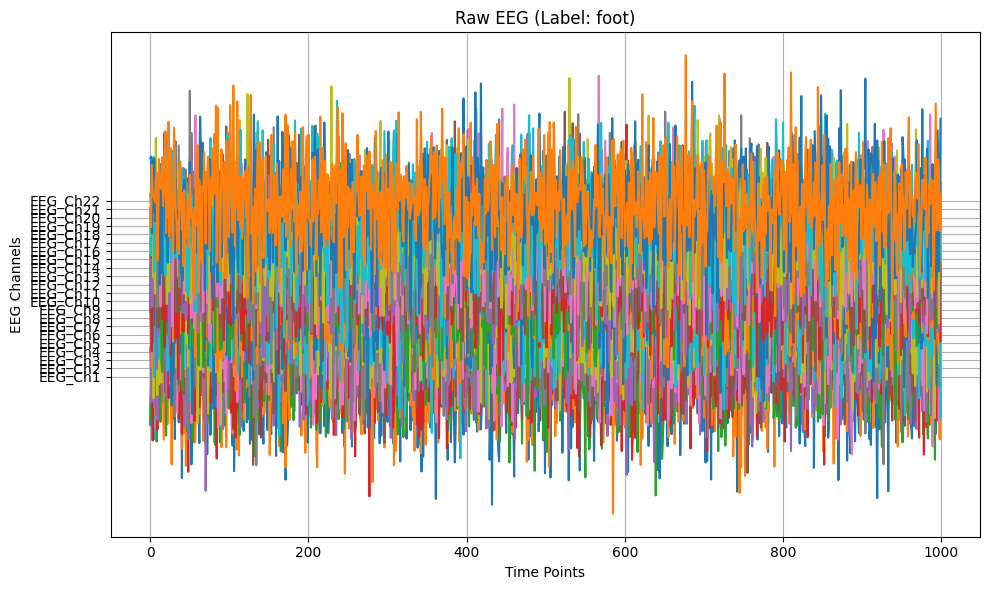

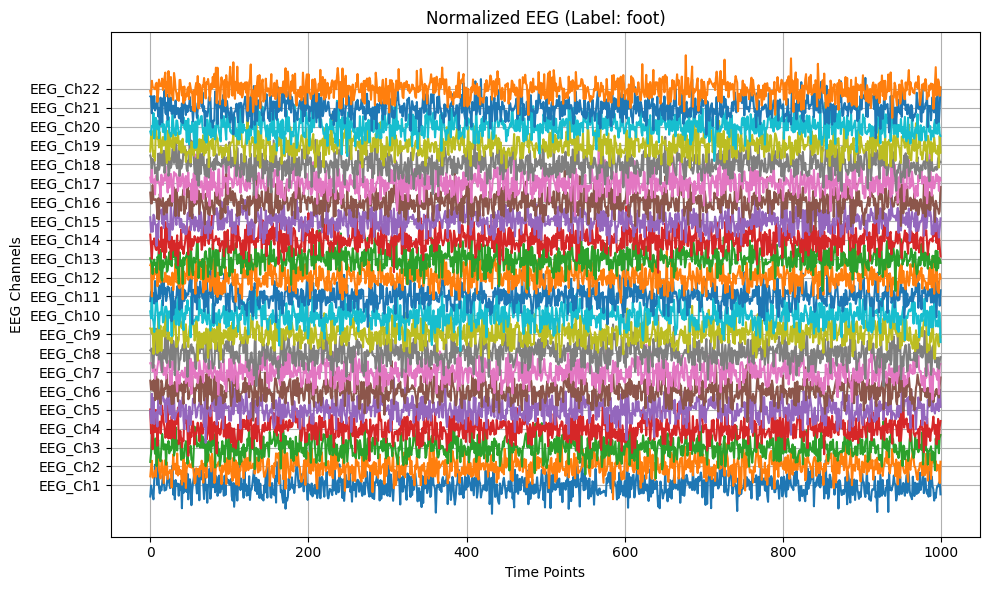


--- EEG Signal Frequency-Domain Visualization (FFT) ---


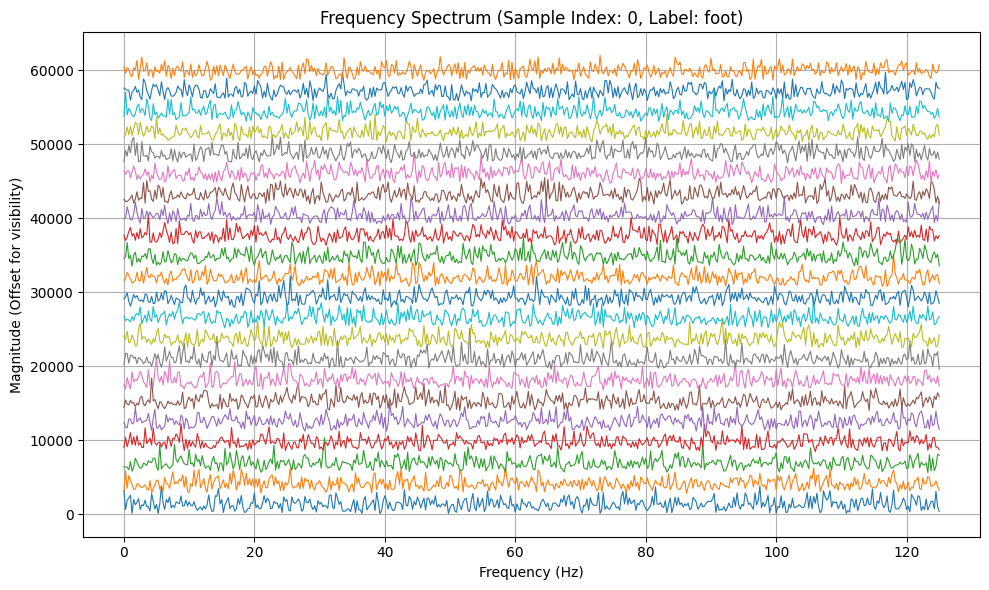


--- Spectrogram-like EEG Heatmap ---


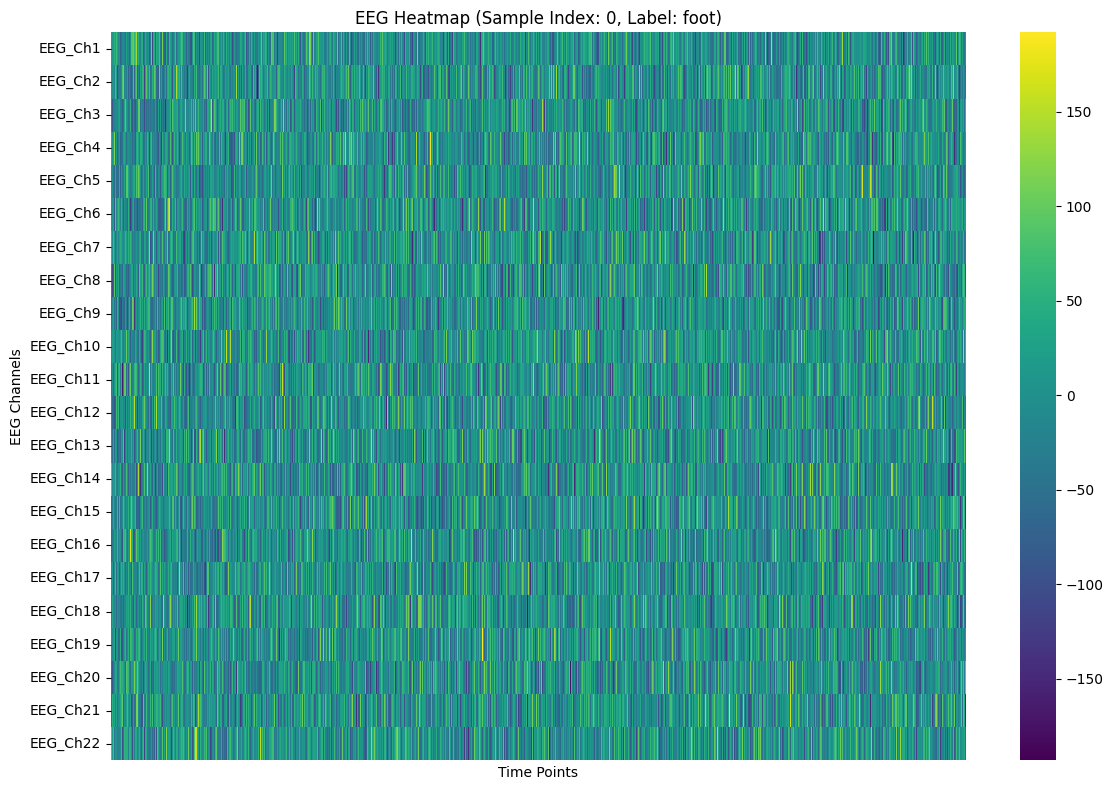


--- EEG Band Power Calculation ---


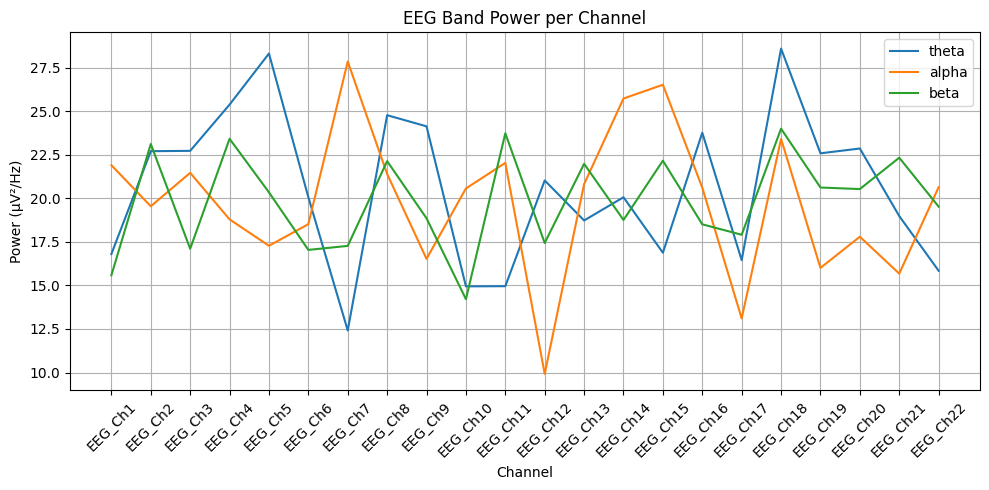


--- PCA and t-SNE Feature Visualization ---


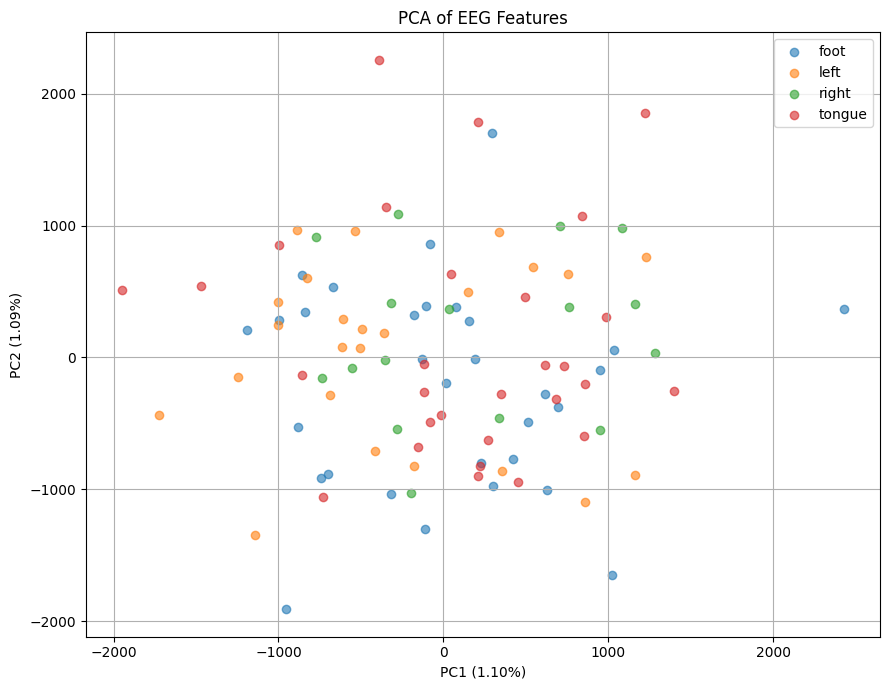

In [6]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy.fft import fft, rfftfreq
from scipy.signal import welch
import random

# --- Parameters for dummy data ---
n_samples = 100
n_channels = 22  # Standard for BCIC IV 2a
n_time_points = 1000  # Assuming 4 seconds at 250 Hz
sf = 250  # Sampling frequency

# Dummy raw EEG data (X)
X = np.random.randn(n_samples, n_channels, n_time_points) * 50

# Dummy labels (y)
labels = ['left', 'right', 'foot', 'tongue']
y = np.array(random.choices(labels, k=n_samples))

# EEG channel names
eeg_columns = [f'EEG_Ch{i+1}' for i in range(n_channels)]

# Normalize EEG data
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_time_points)
X_normalized_reshaped = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized_reshaped.reshape(n_samples, n_channels, n_time_points)

# Frequency domain (FFT)
X_freq_real = np.abs(np.fft.rfft(X, axis=-1))

# Windowed features for PCA/t-SNE
X_windows = X  # Placeholder

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# --- Visualization: Raw EEG ---
print("--- Raw EEG Signal Visualization (Sample) ---")
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0] if len(left_indices) > 0 else random.randint(0, n_samples - 1)
sample_data = X[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Comparison: Raw vs Normalized ---
print("\n--- Raw vs. Normalized EEG Signal Comparison ---")
target_class = 'foot'
class_indices = np.where(y == target_class)[0]
sample_idx = class_indices[0] if len(class_indices) > 0 else random.randint(0, n_samples - 1)
raw_sample = X[sample_idx]
norm_sample = X_normalized[sample_idx]
start_time, end_time = 0, raw_sample.shape[1]
raw_clip = raw_sample[:, start_time:end_time]
norm_clip = norm_sample[:, start_time:end_time]
time_points = np.arange(start_time, end_time)

# Raw EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, raw_clip[ch] + ch * 10)
plt.yticks([ch * 10 for ch in range(n_channels)], eeg_columns)
plt.title(f'Raw EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, norm_clip[ch] + ch * 2)
plt.yticks([ch * 2 for ch in range(n_channels)], eeg_columns)
plt.title(f'Normalized EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Frequency-Domain Visualization ---
print("\n--- EEG Signal Frequency-Domain Visualization (FFT) ---")
sample_freq = X_freq_real[sample_idx]
freqs = rfftfreq(n_time_points, d=1/sf)

plt.figure(figsize=(10, 6))
offset = np.max(sample_freq) * 0.5
for ch in range(n_channels):
    plt.plot(freqs, sample_freq[ch] + ch * offset, lw=0.8)
plt.title(f'Frequency Spectrum (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Offset for visibility)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap ---
print("\n--- Spectrogram-like EEG Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

# --- Band Power ---
print("\n--- EEG Band Power Calculation ---")
def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
band_powers = {band: [] for band in bands}

for ch in range(n_channels):
    signal = sample_data[ch]
    for band, band_range in bands.items():
        band_powers[band].append(bandpower(signal, sf, band_range, window_sec=2))

plt.figure(figsize=(10, 5))
for band in bands:
    plt.plot(band_powers[band], label=band)
plt.xticks(np.arange(n_channels), eeg_columns, rotation=45)
plt.title("EEG Band Power per Channel")
plt.xlabel("Channel")
plt.ylabel("Power (μV²/Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PCA Visualization ---
print("\n--- PCA and t-SNE Feature Visualization ---")
X_flat = X_windows.reshape(n_samples, -1)
y_labels = np.argmax(y_categorical, axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(9, 7))
for i in np.unique(y_labels):
    label = label_encoder.classes_[i] if i < len(label_encoder.classes_) else f'Class {i}'
    plt.scatter(X_pca[y_labels == i, 0], X_pca[y_labels == i, 1], label=label, alpha=0.6)
plt.title("PCA of EEG Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# *Model Creation*

In [7]:
# Define input shape from X_train
channels = X.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4

In [8]:
channels

22

In [9]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

In [10]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [11]:
# === Choose your model ===
# model = CNN_LSTM(input_shape=(timesteps, features), num_classes=num_classes, dropoutRate=0.3, l2_reg = 0.002)

model = GRU_Flatten_Model(input_shape=(timesteps, features), num_classes=num_classes)

# model = GRU_Regularized_Model(input_shape=(timesteps, features),num_classes=num_classes,dropout_rate=0.2, l2_reg=0.002)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

I0000 00:00:1753812132.261255      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753812132.261942      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 256)             │         231,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          51,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [12]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=6, 
                               restore_best_weights=True, 
                               mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=5, 
                                 min_lr=1e-6)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100


I0000 00:00:1753812136.887915      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2749 - loss: 1.5559 - val_accuracy: 0.2827 - val_loss: 1.4423 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3786 - loss: 1.3237 - val_accuracy: 0.3332 - val_loss: 1.3912 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4454 - loss: 1.2458 - val_accuracy: 0.3455 - val_loss: 1.4069 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4923 - loss: 1.1530 - val_accuracy: 0.3599 - val_loss: 1.3904 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5811 - loss: 1.0223 - val_accuracy: 0.4251 - val_loss: 1.2700 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6659 - loss: 0.8515 - val_accuracy: 0.4948 - val_loss: 1.1850 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.767

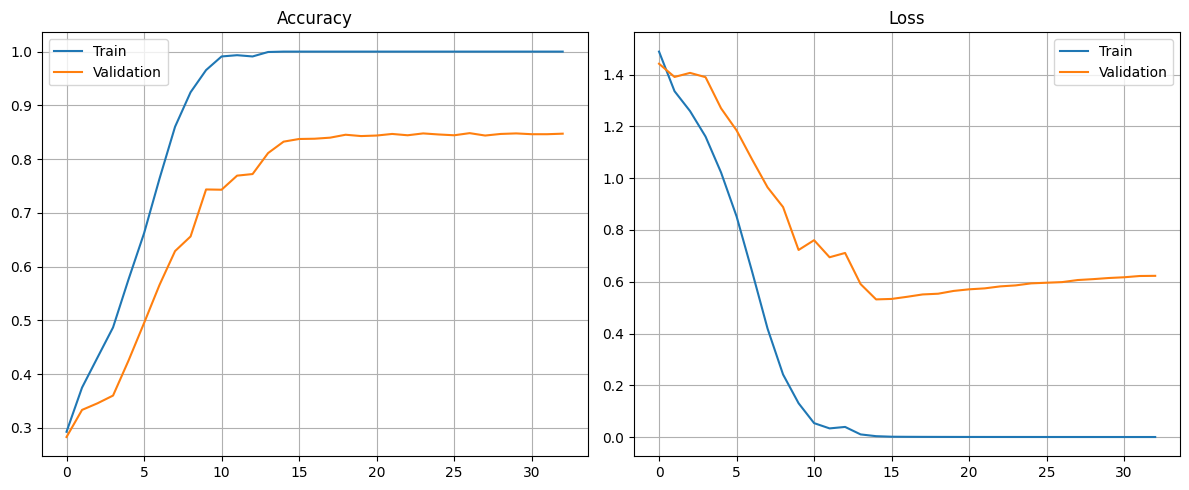

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


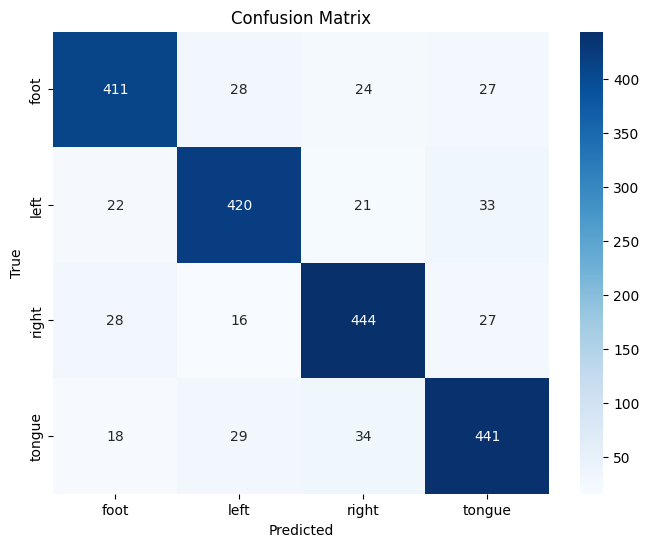

Classification Report:
              precision    recall  f1-score   support

        foot       0.86      0.84      0.85       490
        left       0.85      0.85      0.85       496
       right       0.85      0.86      0.86       515
      tongue       0.84      0.84      0.84       522

    accuracy                           0.85      2023
   macro avg       0.85      0.85      0.85      2023
weighted avg       0.85      0.85      0.85      2023



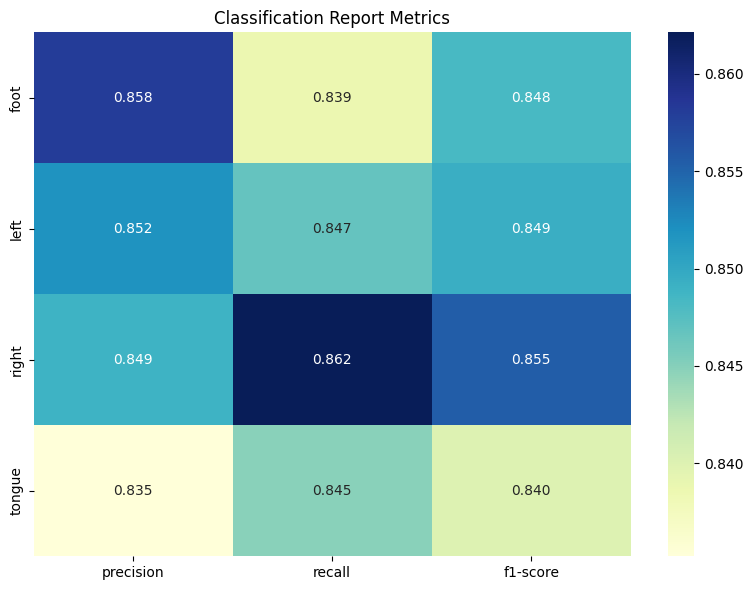

In [14]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


report = classification_report(y_true, y_pred, target_names=labels,output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), 
            annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Classification Report Metrics')
plt.tight_layout()
plt.savefig('classification_report_heatmap.png', dpi=300)